In [1]:
import glob
import numpy as np
import cv2
from PIL import Image
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt

filelist = glob.glob("./PictureStackImages/*.JPG")
filelist

['./PictureStackImages/8.JPG',
 './PictureStackImages/12.JPG',
 './PictureStackImages/5.JPG']

### The g metrics obtained through camera radiometric calibration (in the RadiometryCalibration.ipynb file):

In [2]:
g = [1.79526731311, 1.85695064051, 1.69743757856]

### Shutter speed information extracted from the images' EXIF:

In [3]:
def shutter_speed(filelist):
    speed_arr = []
    for file in filelist:
        exif_data = Image.open(file)._getexif()
        speed = float(10/exif_data[33434][1])
        speed_arr.append(speed)
    return speed_arr
speed_arr = shutter_speed(filelist)
log_speed = np.log(speed_arr)

#a1 = T1/T
a1 = float(speed_arr[0]/speed_arr[2])
#a2 = T2/T
a2 = float(speed_arr[1]/speed_arr[2])

In [4]:
im1 = cv2.imread(filelist[2])
im2 = cv2.imread(filelist[0])
im3 = cv2.imread(filelist[1])

### This is for testing on a fraction of the original image (since our original images are 16 megapixels, it takes pretty long to run)

In [5]:
# Please rename the above im1 -> im11, im2 -> im21, im3 -> im31 before uncommenting and run the code below
# width = 3264
# length = 4928

# wi_start = int((width - 500)/2)
# len_start = int((length - 500)/2)

# im1 = im11[wi_start:wi_start + 500, len_start:len_start + 500, :]
# im2 = im21[wi_start:wi_start + 500, len_start:len_start + 500, :]
# im3 = im31[wi_start:wi_start + 500, len_start:len_start + 500, :]

### Plot the 3 input images

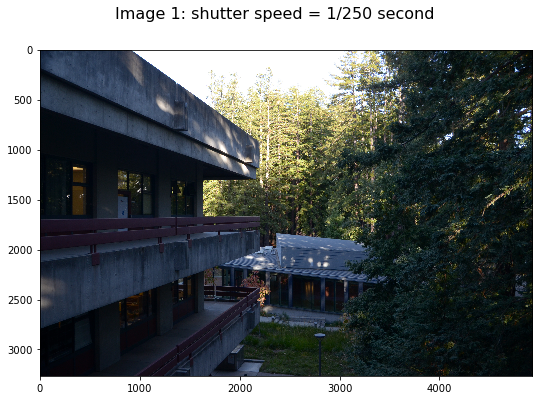

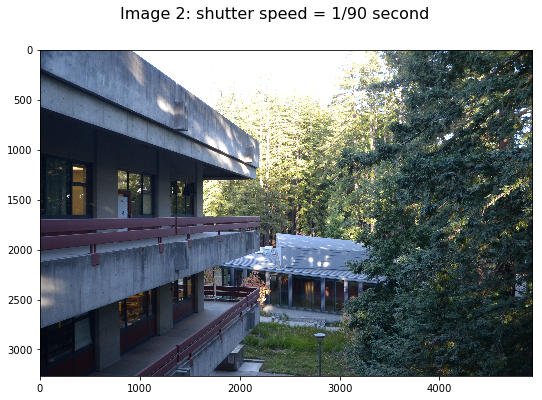

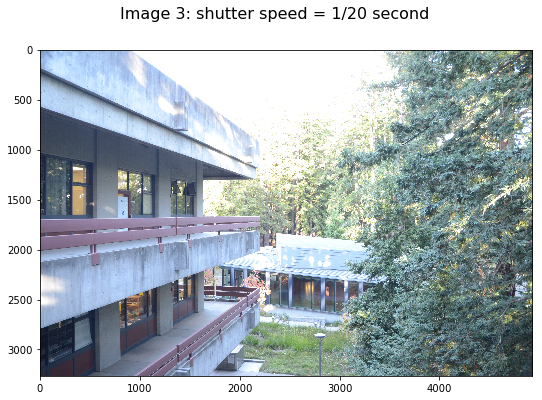

In [6]:
plt.figure(figsize=(12,6)); plt.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
plt.suptitle('Image 1: shutter speed = 1/250 second', fontsize=16) ; plt.show()
plt.figure(figsize=(12,6)); plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
plt.suptitle('Image 2: shutter speed = 1/90 second', fontsize=16) ; plt.show()
plt.figure(figsize=(12,6)); plt.imshow(cv2.cvtColor(im3, cv2.COLOR_BGR2RGB))
plt.suptitle('Image 3: shutter speed = 1/20 second', fontsize=16) ; plt.show()

### Calculate $B' = B^{g}$

In [7]:
im1b = np.zeros(im1.shape, np.float32)
im2b = np.zeros(im1.shape, np.float32)
im3b = np.zeros(im1.shape, np.float32)

for i in range(3):
    im1b[:,:,i] = np.power(im1[:,:,i],g[i])
    im2b[:,:,i] = np.power(im2[:,:,i],g[i])
    im3b[:,:,i] = np.power(im3[:,:,i],g[i])

### Since images used is 4928x3264 (16 mpx), it will take sometime to run the following code fractions, please be patience, thank you very much! 

## HDR algorithm 1: for each pixel, use the pixel value of the image with largest exposure time such that the pixel is not saturated

In [8]:
hdr_im1 = np.zeros(im1.shape, np.float32)
hdr_im1b = np.zeros(im1.shape, np.float32)
for i in range(im1.shape[0]):
    for j in range(im1.shape[1]):
        # Case 1: pixel is not saturated in any image
        if im3[i,j,0] < 255 and im3[i,j,1] < 255 and im3[i,j,2] < 255:
            hdr_im1[i,j,:] = im3[i,j,:]/a2
            hdr_im1b[i,j,:] = im3b[i,j,:]/a2
        # Case 2: pixel is not saturated in image 3 but not in image 2
        elif im2[i,j,0] < 255 and im2[i,j,1] < 255 and im2[i,j,2] < 255:
            hdr_im1[i,j,:] = im2[i,j,:]/a1
            hdr_im1b[i,j,:] = im2b[i,j,:]/a1  
        # Case 3: pixel is saturated in image 2
        else:
            hdr_im1[i,j,:] = im1[i,j,:]
            hdr_im1b[i,j,:] = im1b[i,j,:]  

### Plot the histogram for the intermediate HDR image by method 2 (before tone-mapping)

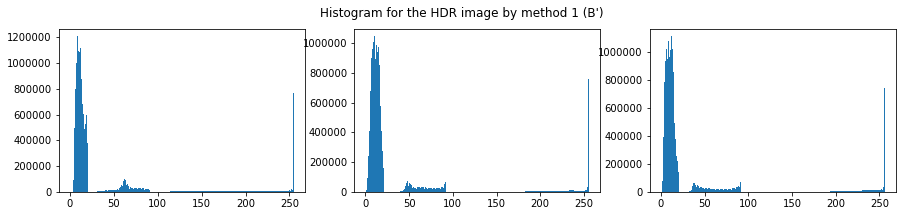

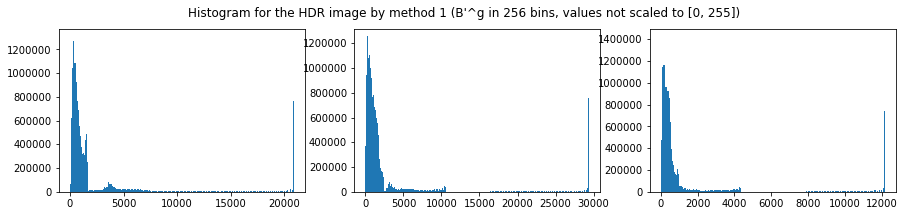

In [9]:
plt.figure(figsize=(15,3)); 
plt.subplot(1,3,1); plt.hist(hdr_im1[:,:,0].ravel(),256,[0,255]) 
plt.subplot(1,3,2); plt.hist(hdr_im1[:,:,1].ravel(),256,[0,256])
plt.subplot(1,3,3); plt.hist(hdr_im1[:,:,2].ravel(),256,[0,256])
plt.suptitle('Histogram for the HDR image by method 1 (B\') ')
plt.show()

plt.figure(figsize=(15,3)); 
plt.subplot(1,3,1); plt.hist(hdr_im1b[:,:,0].ravel(),256,[0,255**g[0]]) 
plt.subplot(1,3,2); plt.hist(hdr_im1b[:,:,1].ravel(),256,[0,255**g[1]])
plt.subplot(1,3,3); plt.hist(hdr_im1b[:,:,2].ravel(),256,[0,255**g[2]])
plt.suptitle('Histogram for the HDR image by method 1 (B\'^g in 256 bins, values not scaled to [0, 255])')
plt.show()

### Tone-mapping: using Debvec Tone-mapping from the package provided by OpenCV with gamma = 2.2

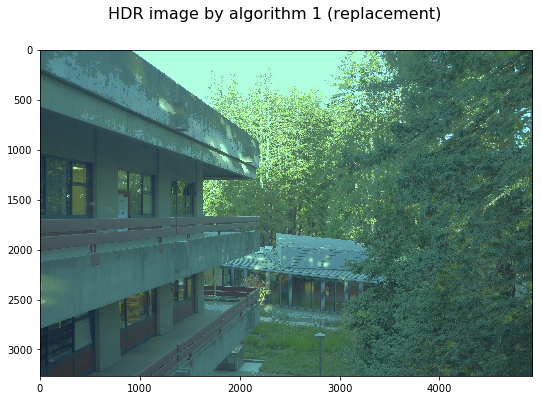

True

In [10]:
tonemap1 = cv2.createTonemapDurand(gamma=2.2)
res_debvec = tonemap1.process(hdr_im1b.copy())
res_debvec_8bit = np.clip(res_debvec*255, 0, 255).astype('uint8')
#Plot the resulting image:

plt.figure(figsize=(12,6)); plt.imshow(cv2.cvtColor(res_debvec_8bit, cv2.COLOR_BGR2RGB))
plt.suptitle('HDR image by algorithm 1 (replacement)', fontsize=16) ; plt.show()
#Write to file:
cv2.imwrite("./TonemappedImages/hdr1.jpg", res_debvec_8bit)

## HDR algorithm 2: for each pixel, use the average of the values in the images for which this pixel is not saturated

In [11]:
hdr_im2 = np.zeros(im1.shape, np.float32)
hdr_im2b = np.zeros(im1.shape, np.float32)
for i in range(im1.shape[0]):
    for j in range(im1.shape[1]):
        # Case 1: pixel is not saturated in any image
        if im3[i,j,0] < 255 and im3[i,j,1] < 255 and im3[i,j,2] < 255:
            hdr_im2[i,j,:] = (im3[i,j,:]/a2 + im2[i,j,:]/a1 + im1[i,j,:])/3
            hdr_im2b[i,j,:] = (im3b[i,j,:]/a2 + im2b[i,j,:]/a1 + im1b[i,j,:])/3
        # Case 2: pixel is not saturated in image 3 but not in image 2
        elif im2[i,j,0] < 255 and im2[i,j,1] < 255 and im2[i,j,2] < 255:
            hdr_im2[i,j,:] = (im2[i,j,:]/a1 + im1[i,j,:])/2
            hdr_im2b[i,j,:] = (im2b[i,j,:]/a1 + im1b[i,j,:])/2
        # Case 3: pixel is not saturated in image 3 but not in image 2
        else:
            hdr_im2[i,j,:] = im2[i,j,:]
            hdr_im2b[i,j,:] = im1b[i,j,:] 

### Plot the histogram for the intermediate HDR image by method 2 (before tone-mapping)

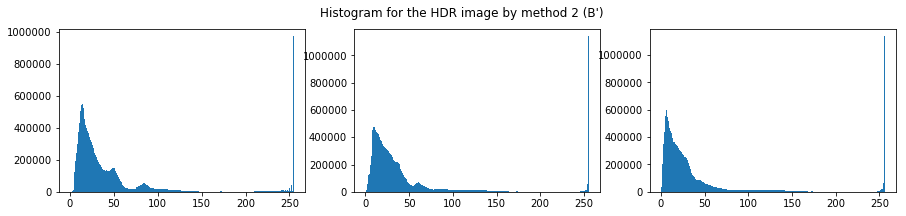

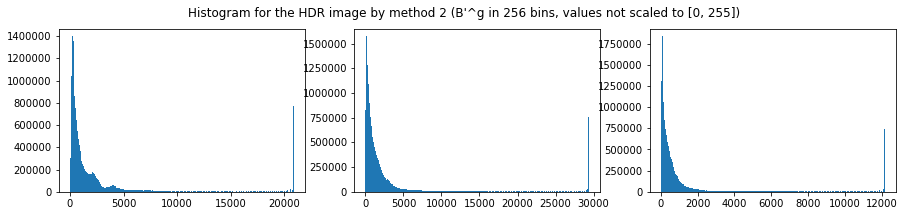

In [12]:
plt.figure(figsize=(15,3)); 
plt.subplot(1,3,1); plt.hist(hdr_im2[:,:,0].ravel(),256,[0,255]) 
plt.subplot(1,3,2); plt.hist(hdr_im2[:,:,1].ravel(),256,[0,256])
plt.subplot(1,3,3); plt.hist(hdr_im2[:,:,2].ravel(),256,[0,256])
plt.suptitle('Histogram for the HDR image by method 2 (B\') ')
plt.show()

plt.figure(figsize=(15,3)); 
plt.subplot(1,3,1); plt.hist(hdr_im2b[:,:,0].ravel(),256,[0,255**g[0]]) 
plt.subplot(1,3,2); plt.hist(hdr_im2b[:,:,1].ravel(),256,[0,255**g[1]])
plt.subplot(1,3,3); plt.hist(hdr_im2b[:,:,2].ravel(),256,[0,255**g[2]])
plt.suptitle('Histogram for the HDR image by method 2 (B\'^g in 256 bins, values not scaled to [0, 255])')
plt.show()

### Tone-mapping: using Debvec Tone-mapping from the package provided by OpenCV with gamma = 2.2

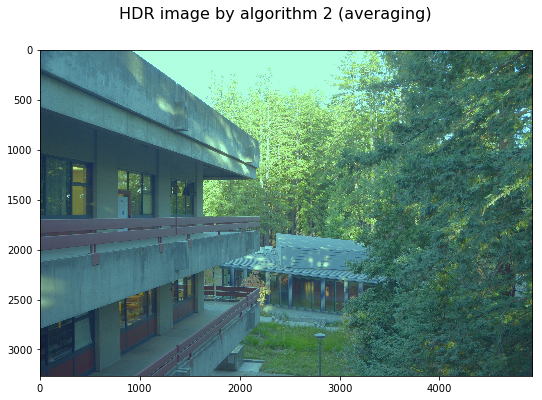

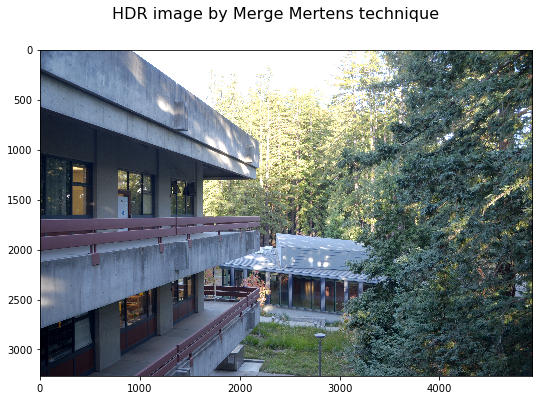

True

In [13]:
tonemap1 = cv2.createTonemapDurand(gamma=2.2)
res_debvec = tonemap1.process(hdr_im2b.copy())
res_debvec_8bit = np.clip(res_debvec*255, 0, 255).astype('uint8')
#Plot the resulting image:
plt.figure(figsize=(12,6)); plt.imshow(cv2.cvtColor(res_debvec_8bit, cv2.COLOR_BGR2RGB))
plt.suptitle('HDR image by algorithm 2 (averaging)', fontsize=16) ; plt.show()
#Write to file:
cv2.imwrite("./TonemappedImages/hdr2.jpg", res_debvec_8bit)

#Using Merge Mertens technique:
img_list = [cv2.imread(file) for file in filelist]
merge_mertens = cv2.createMergeMertens()
res_mertens = merge_mertens.process(img_list)
res_mertens_8bit = np.clip(res_mertens*255, 0, 255).astype('uint8')
#Plot the resulting image:
plt.figure(figsize=(12,6)); plt.imshow(cv2.cvtColor(res_mertens_8bit, cv2.COLOR_BGR2RGB))
plt.suptitle('HDR image by Merge Mertens technique', fontsize=16) ; plt.show()
#Write to file:
cv2.imwrite("./TonemappedImages/hdr_fusion_mertens.jpg", res_mertens_8bit)